# **Modeling - Data Split**

In [2]:
#Models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv("/content/drive/MyDrive/IBE/4th Semester/Master Thesis/Codes/Data/frenchclaim_prep.csv")   #data prepared

In [5]:
# Define response name and features names
#Exposure and ClaimNb are not included in the model as it is part of the calculation of Freq

#Freq is the response variable, group_id used only in terms of split
y, x = df.columns[1], list(df.loc[:, ~df.columns.isin(['Freq', 'group_id', 'Unnamed: 0'])])

print("The response name:", y)
print("The feature names:", x)

The response name: Freq
The feature names: ['VehPower', 'VehAge', 'VehBrand', 'VehGas', 'DrivAge', 'logDensity', 'PolicyRegion']


In [6]:
# split the data into 80% training and 20% test
# Split data into test/train set

# Stratified split by group_id to minimize bias
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(df, groups=df['group_id'])
train_inds, test_inds = next(split)

train = df.iloc[train_inds]
test = df.iloc[test_inds]

# **Random Forest model**

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
# Prepares a default instance of the random forest regressor
#model_rf = RandomForestRegressor(criterion= "poisson", random_state = 42)
# Fits the model on the data
#model_rf.fit(X=train[x], y=train[y])

In [9]:
# Prediction
#y_pred_rf = model_rf.predict(test[x])

In [10]:
#Mean Poisson deviance regression loss.
#out-of-sample on the test data set
#deviance = mean_poisson_deviance(test[y], y_pred_rf)
#print(f"Mean Poisson Deviance: {deviance:.4f}")

In [11]:
#mean squared error
#from sklearn.metrics import mean_squared_error
#mse = mean_squared_error(test[y], y_pred_rf)
#print(f"Mean Squared Error: {mse:.4f}")

In [12]:
#tuning model
#param_grid = {
#    'n_estimators': [25, 50, 100],
#    'max_features': ['sqrt', 'log2', None],
#    'max_depth': [3, 6],
#    'max_leaf_nodes': [3, 6],
#}

In [13]:
#grid_search = GridSearchCV(model_rf,
#                           param_grid=param_grid)
#grid_search.fit(train[x], train[y])
#print(grid_search.best_estimator_)

In [14]:
#Model with the new tuning parameters
#Grid Search output:RandomForestRegressor(criterion='poisson', max_depth=3, max_features='sqrt',
                      #max_leaf_nodes=3, random_state=42)
# Prepares a default instance of the random forest regressor
model_rf_t = RandomForestRegressor(criterion= "poisson", max_depth=3, max_features='sqrt',
                      max_leaf_nodes=3, n_estimators=50, random_state = 42)
# Fits the model on the data
model_rf_t.fit(X=train[x], y=train[y])

RandomForestRegressor(criterion='poisson', max_depth=3, max_features='sqrt',
                      max_leaf_nodes=3, n_estimators=50, random_state=42)

In [15]:
# Prediction
y_pred_rf_t = model_rf_t.predict(test[x])

In [16]:
#Mean Poisson deviance regression loss.
#out-of-sample on the test data set
deviance = mean_poisson_deviance(test[y], y_pred_rf_t)
print(f"Mean Poisson Deviance: {deviance:.4f}")

Mean Poisson Deviance: 1.0770


In [17]:
#mean squared error
mse = mean_squared_error(test[y], y_pred_rf_t)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 1.2305


#**SHAP** **analysis**

Select explanation data

In [18]:
X_explain = train[x].sample(n=1000, random_state=937)
print("Shape of X_explain:", X_explain.shape)

Shape of X_explain: (1000, 7)


In [19]:
!pip install shap
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.6 MB/s eta 0:00:00


# **Random Forest with TreeSHAP**

In [20]:
rf_explainer = shap.TreeExplainer(model_rf_t)
shap_rf = rf_explainer(X_explain)

**Waterfall plot of first observation**

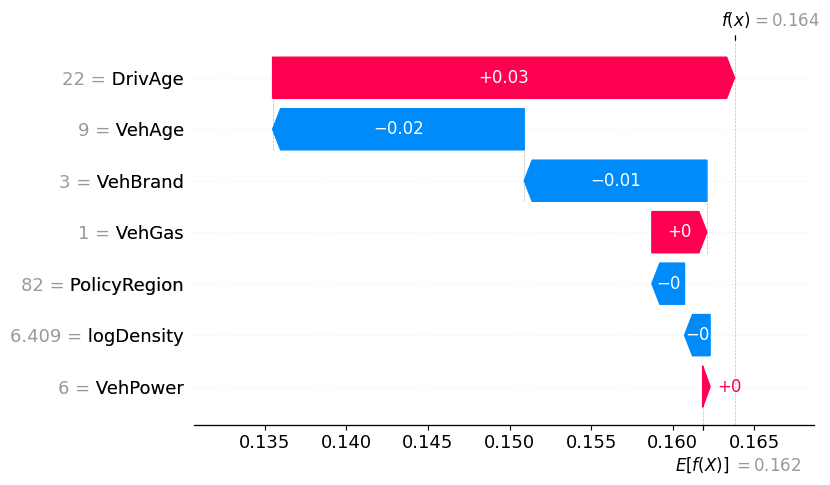

In [21]:
shap.plots.waterfall(shap_rf[0])

**SHAP importance**

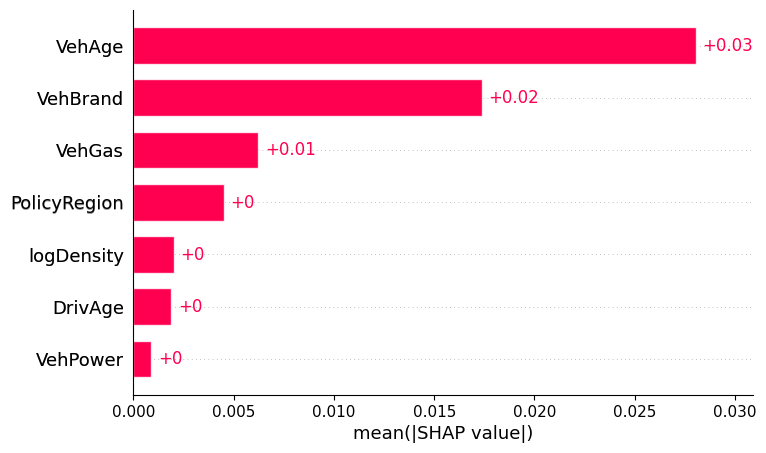

In [22]:
shap.plots.bar(shap_rf)

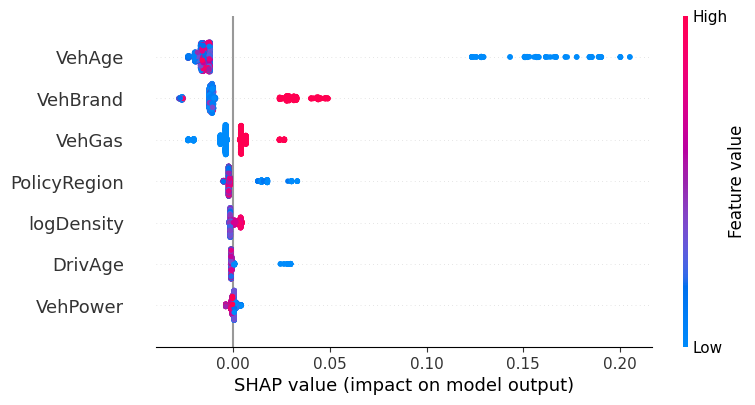

In [23]:
_ = shap.plots.beeswarm(shap_rf)

**SHAP dependence plots**

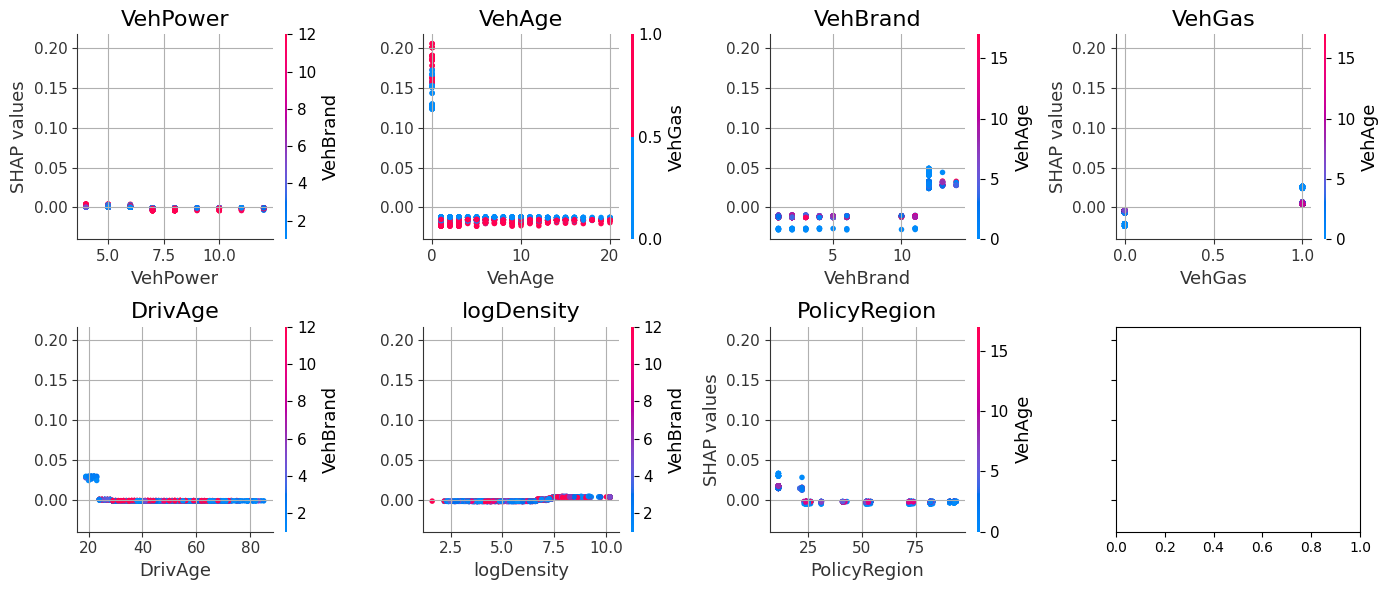

In [24]:
def all_dep_plots(x, shap_values, X):
    """Dependence plots for all features x."""
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 6), sharey=True)

    for i, ax in enumerate(axes.flat):
        if i < len(x):
            xvar = x[i]
            # Access the raw SHAP values from the Explanation object
            shap.dependence_plot(
                xvar,
                shap_values, # Extract the raw values
                features=X,
                ax=ax,
                show=False,
            )
            ax.set_title(xvar, fontdict={"size": 16})
            ax.set_ylabel("SHAP values" if i % 3 == 0 else "")
            ax.grid()

    plt.tight_layout()

# Assuming 'shap_rf' is the Explanation object
all_dep_plots(x, shap_rf.values, X_explain) # Pass the raw SHAP values

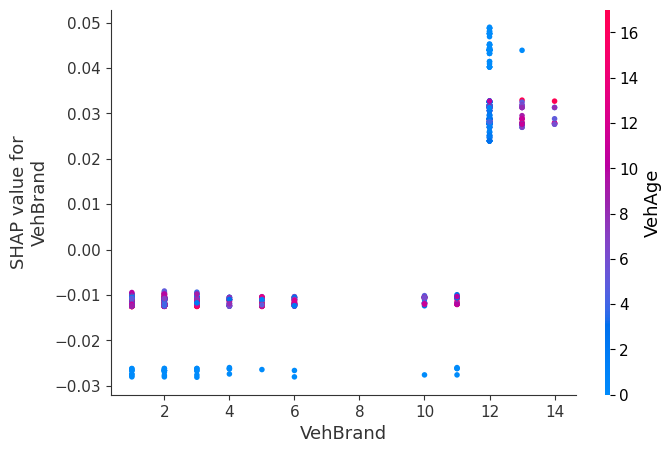

In [25]:
shap.dependence_plot(2, shap_rf.values, X_explain)

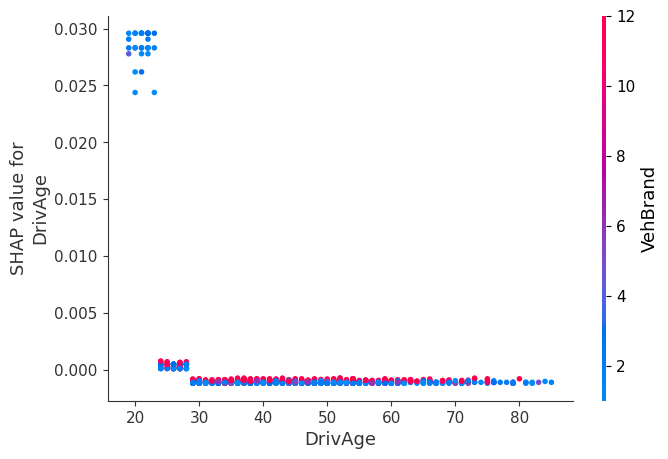

In [26]:
shap.dependence_plot(4, shap_rf.values, X_explain)

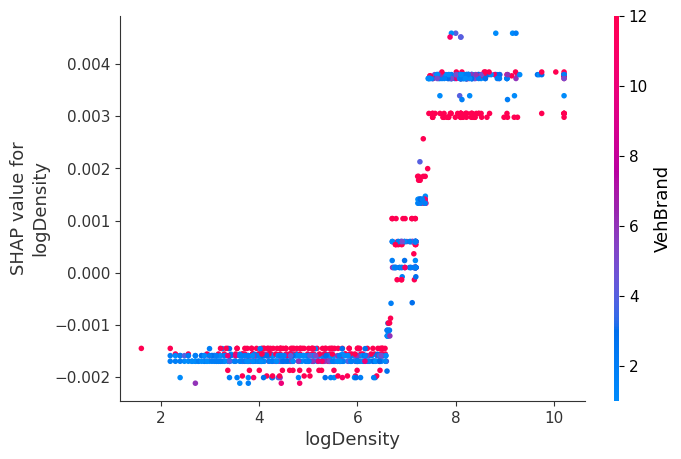

In [27]:
shap.dependence_plot(5, shap_rf.values, X_explain)

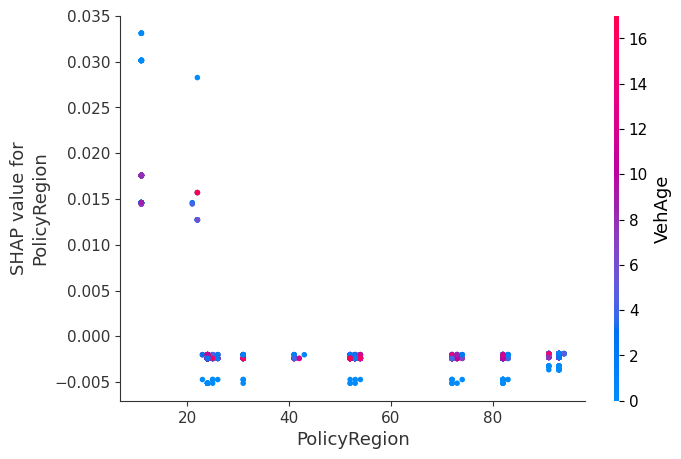

In [28]:
shap.dependence_plot(6, shap_rf.values, X_explain)

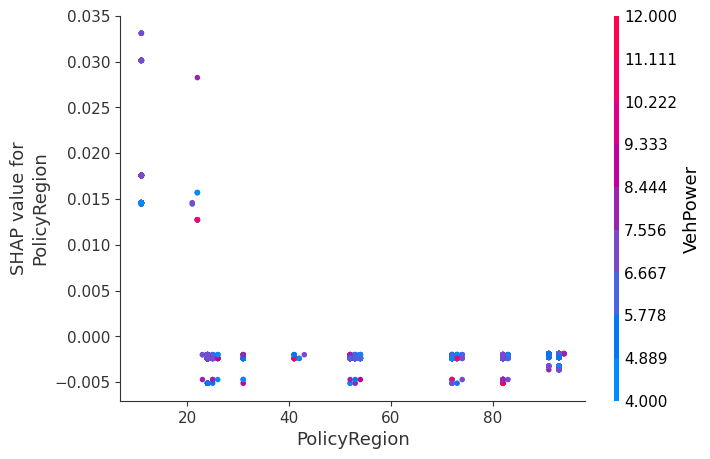

In [29]:
scatter = shap.dependence_plot("PolicyRegion", shap_rf.values, X_explain, interaction_index="VehPower")

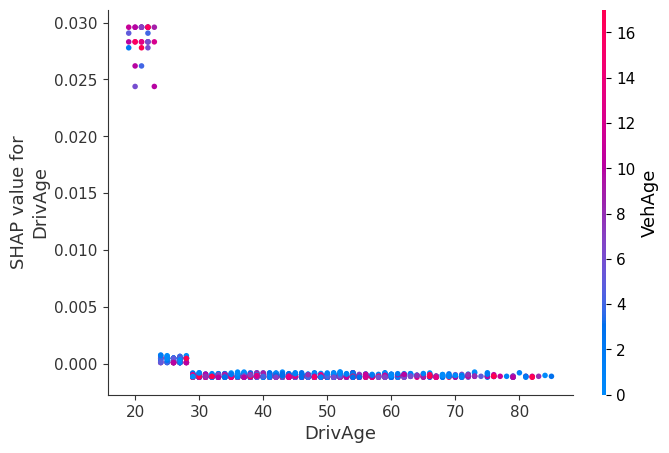

In [30]:
scatter = shap.dependence_plot("DrivAge", shap_rf.values, X_explain, interaction_index="VehAge")

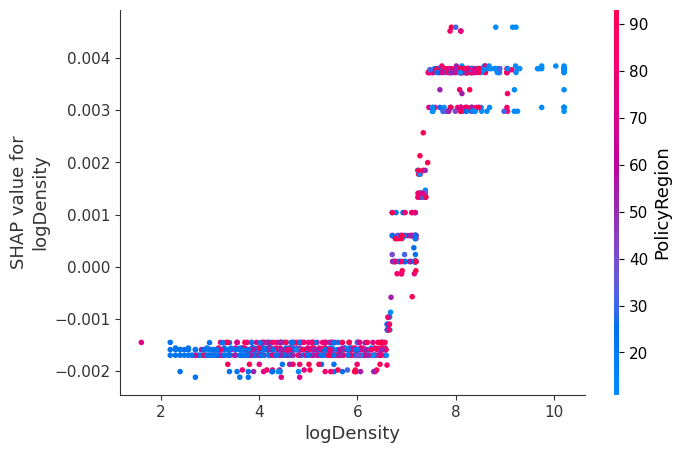

In [31]:
scatter = shap.dependence_plot("logDensity", shap_rf.values, X_explain, interaction_index="PolicyRegion")